In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, Flatten, Dense, Activation, BatchNormalization, Dropout, Add, MaxPool2D
from tensorflow.keras.models import Model
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from math import sqrt
import numpy as np
from sklearn.model_selection import train_test_split
import os
import matplotlib.pyplot as plt

# Dataset

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
X_train = X_train / 255
X_test = X_test / 255

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(50000, 32, 32, 3)
(50000, 10)
(10000, 32, 32, 3)
(10000, 10)


In [4]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=10000, random_state=2)

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

(40000, 32, 32, 3)
(40000, 10)
(10000, 32, 32, 3)
(10000, 10)


# Helper fucntions

In [5]:
# source: https://github.com/song9446/Genetic-CNN/blob/master/genetic_cnn.py
input_shape = (32, 32, 3)

STAGE_NUM = 3
NODE_NUM = [3, 4, 5]
FILTER_NUM = [8, 16, 32] 
KERNEL_SIZE = [3, 3, 3]
L = sum(n*(n-1) // 2 for n in NODE_NUM)
i = 0
L_cumsum = [None] * STAGE_NUM

for s in range(STAGE_NUM):
    L_cumsum[s] = [0] * (NODE_NUM[s] - 1)
    for n in range(NODE_NUM[s]-1):
        L_cumsum[s][n] = i
        i += n + 1

def Conv2DReluBatchNorm(filters, kernel_size, X):
    return Activation(activation='relu')(
               BatchNormalization()(
                    Conv2D(filters, kernel_size, padding='same')(
                        X)))
    
def is_head(gene, stage, node):
    if node == 0: 
        return True
    i = L_cumsum[stage][node-1]
    return sum(gene[i:i+node]) == 0
    
def is_leaf(gene, stage, node):
    if node == NODE_NUM[stage] - 1:
        return True
    return sum(gene[L_cumsum[stage][i] + node] for i in range(node, NODE_NUM[stage] - 1)) == 0
    
def InputLayer(input_shape, X):
    return Conv2D(input_shape=input_shape, filters=8, padding="same", kernel_size=3, activation="relu")(
                X)
    
def OutputLayer(output_shape, X):
    return Dense(output_shape, activation="softmax")(
                    Dropout(0.5)(
                        X))
    
def get_model_from_gene(gene):
    tf.compat.v1.reset_default_graph()
    
    convs = [None] * sum(NODE_NUM)
    inputs = tf.keras.Input(shape=input_shape)
    input_layer = InputLayer(input_shape, inputs)
    last_layer = input_layer
    
    for s in range(STAGE_NUM):
        for n in range(NODE_NUM[s]): # stage s node n
            if is_head(gene, s, n):
                convs[s*STAGE_NUM+n] = Conv2DReluBatchNorm(FILTER_NUM[s], KERNEL_SIZE[s], last_layer) 
            else:
                cumsum = L_cumsum[s][n-1]
                input_nodes = [convs[s*STAGE_NUM+i] for i in range(n) if gene[cumsum+i] > 0]
                add = Add()(input_nodes) if len(input_nodes) > 1 else input_nodes[0]
                convs[s*STAGE_NUM+n] = Conv2DReluBatchNorm(FILTER_NUM[s], KERNEL_SIZE[s], add)
                
        leafs = [convs[s*STAGE_NUM+n] for n in range(NODE_NUM[s]) if is_leaf(gene, s, n)]
        add = Add()(leafs) if len(leafs) > 1 else leafs[0]
        pool = MaxPool2D(pool_size=3, strides=2)(add)
        last_layer = pool
        
    last_layer = Dense(128, activation="softmax")(Flatten()(last_layer))
        
    output_layer = OutputLayer(10, last_layer)
    
    model = Model(inputs=inputs, outputs=output_layer)
    model.compile(loss=categorical_crossentropy, optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])
    
    return model

def evaluate(model):
    model.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_val, y_val), verbose=0)
    loss, accuracy = model.evaluate(X_test, y_test, verbose=0)
    return accuracy

In [6]:
def tournament_selection(pop, pop_fitness, selection_size, tournament_size=4): # with replacement
    selected_indices = []
    indices = np.arange(len(pop))

    while len(selected_indices) < selection_size:   
        np.random.shuffle(indices)
        
        to_remove_indices = []

        for i in range(0, len(indices), tournament_size):
            if len(selected_indices) >= selection_size:
                break
                
            best_index = i

            for j in range(i+1, i+tournament_size):
                if j >= len(indices):
                    break
                if pop_fitness[indices[j]] > pop_fitness[indices[best_index]]:
                    best_index = j

            to_remove_indices.append(indices[best_index])
            selected_indices.append(indices[best_index])
            
        indices = np.delete(indices, np.isin(indices, to_remove_indices))
        
    return np.array(selected_indices)

In [7]:
def crossover(pop, p_c, q_c, stages):
    num_individuals = len(pop)
    num_parameters = len(pop[0])
    offspring = []

    np.random.shuffle(pop)

    for i in range(0, num_individuals, 2):
        offspring1 = np.copy(pop[i])
        offspring2 = np.copy(pop[i+1])
        
        r = np.random.rand()
        
        if r >= p_c:
            offspring.append(offspring1)
            offspring.append(offspring2)
            continue

        current_index = 0
        d = 0

        #print(f"swap gene {i} and gene {i+1}")
        for i in range(len(stages)):
            chance = np.random.rand()
            d = stages[i] * (stages[i] - 1) // 2
            if chance < q_c:
                temp1 = np.copy(offspring1[current_index:current_index+d])
                temp2 = np.copy(offspring2[current_index:current_index+d])
                #print(f"swap {temp1} with {temp2}")
                offspring1[current_index:current_index+d] = temp2
                offspring2[current_index:current_index+d] = temp1

            current_index += d

        offspring.append(offspring1)
        offspring.append(offspring2)
    
    return np.array(offspring)

'''pop = pop = np.random.randint(2, size=(4, 19))
print(pop, "\n")
print(crossover(pop, 1, 1, [3, 4, 5]))'''

'pop = pop = np.random.randint(2, size=(4, 19))\nprint(pop, "\n")\nprint(crossover(pop, 1, 1, [3, 4, 5]))'

In [8]:
def mutate(pop, p_m, q_m):
    offspring = np.copy(pop)
    
    for i in range(len(offspring)):
        r = np.random.rand()
        if r > p_m:
            continue       
            
        for j in range(len(offspring[0])):
            chance = np.random.rand()
            if chance < q_m:
                if offspring[i][j] == 0:
                    offspring[i][j] = 1
                else:
                    offspring[i][j] = 0
                #print(f"gene {i} is mutated at {j}")
                
    return offspring

'''pop = np.random.randint(2, size=(20, 19))
print(pop, "\n")
print(mutate(pop, 0.8, 0.05))'''

'pop = np.random.randint(2, size=(20, 19))\nprint(pop, "\n")\nprint(mutate(pop, 0.8, 0.05))'

In [9]:
def genetic_algorithm(pop, fitness_record, p_c, q_c, p_m, q_m):
    pop_fitness = np.array([np.mean(fitness_record[to_string(gene)]) for gene in pop])
    selection_size = len(pop)

    # selection
    selected_indices = proportional_selection(pop, pop_fitness, selection_size)
    offspring = pop[selected_indices]
    # crossover
    offspring = crossover(offspring, p_c=p_c, q_c=q_c, stages=[3, 4, 5])
    # mutation
    offspring = mutate(pop, p_m, q_m)
    # evaluation
    for i in range(len(offspring)):
        gene = offspring[i]
        print(f"process gene {i}")
        fitness = evaluate(get_model_from_gene(gene))
        str_gene = to_string(gene)
        if str_gene in fitness_record:
            fitness_record[str_gene].append(fitness)
        else:
            fitness_record[str_gene] = [fitness]

    return offspring, fitness_record

In [10]:
def POPOP(pop, fitness_record, p_c=0.2, q_c=0.2, p_m=0.8, q_m=0.05, random_state=None):
    '''
    Input:
    pop: population of current generation.
    fitness_record: a dict containing all fitness values of each gene.

    Output:
    pop and fitness_record of next generation.
    '''
    np.random.seed(random_state)
    
    selection_size = len(pop)

    # P
    pop_fitness = [np.mean(fitness_record[to_string(gene)]) for gene in pop]

    # O
    offspring = crossover(pop=pop, p_c=p_c, q_c=q_c, stages=[3, 4, 5])
    offspring = mutate(pop=pop, p_m=p_m, q_m=q_m)
    
    for i in range(len(offspring)):
        print(f"processing gene {i}")
        str_gene = to_string(offspring[i])
        fitness = evaluate(get_model_from_gene(offspring[i]))
        if str_gene in fitness_record:
            fitness_record[str_gene].append(fitness)
        else:
            fitness_record[str_gene] = [fitness]
    
    offspring_fitness = [np.mean(fitness_record[to_string(gene)]) for gene in offspring]
    
    # P + O
    PO_pool = np.vstack([pop, offspring])
    PO_fitness = np.copy(pop_fitness)
    for f in offspring_fitness:
        PO_fitness = np.append(PO_fitness, f)

    # selection
    selected_indices = tournament_selection(PO_pool, PO_fitness, selection_size=selection_size, tournament_size=4)
    
    # P
    new_pop = np.array(PO_pool[selected_indices])
    '''for index in selection_indices:
        gene_str = to_string(PO_pool[index])
        fitness = PO_fitness[index]
        if str_gene in fitness_record:
            fitness_record[str_gene].append(fitness)
        else:
            fitness_record[str_gene] = [fitness]'''
    
    return new_pop, fitness_record

In [11]:
def to_string(gene):
    s = ""
    for i in gene:
        s += str(i)
    return s
    
def read_pop(gen_num):
    path = os.path.join("pop", f"{gen_num}.txt")
    pop = []
    with open(path) as file:
        lines = file.readlines()
        for line in lines:
            ind = []
            for bit in line.strip():
                if bit in "01":
                    ind.append(int(bit))
            pop.append(np.array(ind))
    return np.array(pop)

def read_fitness_record(gen_num):
    path = os.path.join("fitness_record", f"{gen_num}.txt")
    fitness_record = {}
    with open(path) as file:
        lines = file.readlines()
        for line in lines:
            ind = []
            values = line.strip().split(" ")
            fitness_record[values[0]] = []
            for fitness in values[1:]:
                fitness_record[values[0]].append(float(fitness))
    return fitness_record

def write_pop(pop, gen_num):
    path = os.path.join("pop", f"{gen_num}.txt") 
    with open(path, 'w') as file:
        for gene in pop:
            for i in gene:
                file.write(f"{i} ")
            file.write('\n')

def write_fitness_record(fitness_record, gen_num):
    path = os.path.join("fitness_record", f"{gen_num}.txt")
    with open(path, 'w') as file:
        for gene, fitness_his in fitness_record.items():
            file.write(f"{gene} ")
            for fitness in fitness_his:
                file.write(f"{fitness} ")
            file.write('\n')

# Experiment

In [ ]:
# 0th generation
pop = np.random.randint(2, size=(20, 19))
fitness_record = {}

for i  in range(len(pop)):
    print(f"processing gene {i}")
    str_gene = to_string(pop[i])
    fitness = evaluate(get_model_from_gene(pop[i]))
    if str_gene in fitness_record:
        fitness_record[str_gene].append(fitness)
    else:
        fitness_record[str_gene] = [fitness]

print(pop)
print(fitness_record)

write_pop(pop, 0)
write_fitness_record(fitness_record, 0)

In [ ]:
gen_num = 22 # ordinal number of current generation, used to find next generation

pop = read_pop(gen_num)
fitness_record = read_fitness_record(gen_num)

# make sure the shape is correct
count = 0
for _, values in fitness_record.items():
    for _ in values:
        count += 1
print(count)
print(pop.shape)

pop, fitness_record = POPOP(pop, fitness_record, p_c=0.2, q_c=0.2, p_m=0.8, q_m=0.05)

print(pop)
print(fitness_record)

write_pop(pop, gen_num+1)
write_fitness_record(fitness_record, gen_num+1)

In [12]:
gen_num = 34

pop = read_pop(gen_num)
fitness_record = read_fitness_record(gen_num)

for gene in pop:
    g = to_string(gene)
    print(f"{g}: {np.mean(fitness_record[g]):.4f}" )

1011000000100110001: 0.7196
1011000100110110001: 0.7213
0111000000100100010: 0.7296
1011000000110110001: 0.7150
1011000000100110001: 0.7196
1011000000100110001: 0.7196
1011000000110110001: 0.7150
1011100000110110001: 0.7383
0111000000100100011: 0.7244
1011000000110110001: 0.7150
1011000010100110001: 0.7280
0111100000111111001: 0.7146
1011000000100110001: 0.7196
1001000000100110001: 0.7194
0011100000110111001: 0.7194
1011000000100110001: 0.7196
1011001000100110001: 0.7295
1011000010100110001: 0.7280
1011000000100110001: 0.7196
1001000000100110001: 0.7194


In [13]:
for i in range(35):
    pop = read_pop(i)
    fitness_record = read_fitness_record(i)

    record = {}
    for key, value in fitness_record.items():
        record[key] = np.mean(value)

    best_fitness = 0
    best_gene = ""
    for gene in pop:
        if record[to_string(gene)] > best_fitness:
            best_fitness = record[to_string(gene)]
            best_gene = to_string(gene)

    print(f"gen {i+1:>2}, best ind: {best_gene}, fitness: {best_fitness.round(4)}")

gen  1, best ind: 1010010110100111110, fitness: 0.73
gen  2, best ind: 1010010110110111110, fitness: 0.7312
gen  3, best ind: 1101000001011010111, fitness: 0.7185
gen  4, best ind: 0011011001011000001, fitness: 0.7214
gen  5, best ind: 1010011001011000001, fitness: 0.7235
gen  6, best ind: 1010010110110110110, fitness: 0.7219
gen  7, best ind: 1001100001011010111, fitness: 0.7378
gen  8, best ind: 1001100001011010111, fitness: 0.7373
gen  9, best ind: 1001100001011010111, fitness: 0.7373
gen 10, best ind: 0111011011111000110, fitness: 0.7258
gen 11, best ind: 0010001001100110001, fitness: 0.7317
gen 12, best ind: 0100001001100110101, fitness: 0.7348
gen 13, best ind: 0100001001101110111, fitness: 0.7415
gen 14, best ind: 0100001001101110111, fitness: 0.7415
gen 15, best ind: 1100001001101110111, fitness: 0.7375
gen 16, best ind: 0110010011110011111, fitness: 0.7435
gen 17, best ind: 0110010011110011111, fitness: 0.7435
gen 18, best ind: 1011001000100111001, fitness: 0.7402
gen 19, best

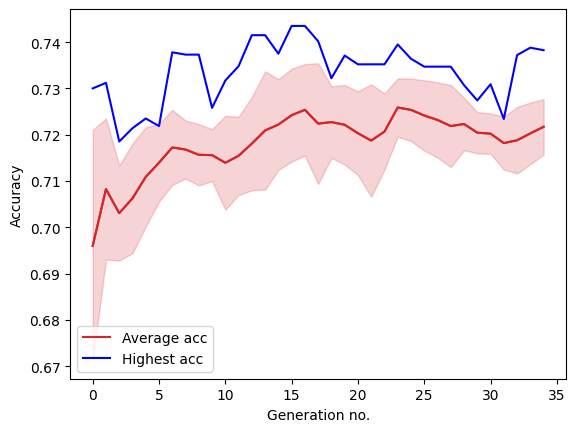

In [14]:
n_gen = 35

x = np.linspace(0, n_gen-1, n_gen)
mean = []
std = []
max_acc = []

for i in range(n_gen):
    pop = read_pop(i)
    fitness_record = read_fitness_record(i)

    acc = []
    max_acc_gen = float("-inf")
    for gene in pop:
        str_gene = to_string(gene)
        acc.append(np.mean(fitness_record[str_gene]))
        if np.mean(fitness_record[str_gene]) > max_acc_gen:
            max_acc_gen = np.mean(fitness_record[str_gene])

    mean.append(np.mean(acc))
    std.append(np.std(acc))
    max_acc.append(max_acc_gen)

mean = np.array(mean)
std = np.array(std)
max_acc = np.array(max_acc)
    
fig, ax = plt.subplots()
ax.plot(x, mean, '-', label="Average acc", color='tab:red')
ax.fill_between(x, mean - std, mean + std, alpha=0.2, color='tab:red')
ax.plot(x, mean, '-', color='tab:red')
ax.plot(x, max_acc, "-", label="Highest acc", color="b")

plt.xlabel("Generation no.")
plt.ylabel("Accuracy")
plt.legend()

plt.savefig("result.png")